# DS mentoring program. Module 2: regression

## Summary

**Baseline:**

MSE: 1.3370143751900183 

MAE: 0.8219447429298781

R2: 0.9757277725676223 

**Best results:**

1. **Polynomial transformation with 3 degrees**

MSE: 0.0011062759180007794

MAE: 0.02639051565453012

R2: 0.9999799302167751

2. **Square transformation (partly included in polynomial transformation)**

MSE: 0.004743364040308849

MAE: 0.04706063204250682

R2: 0.9999142924051666

3. **Square root transformation**

MSE: 0.035095420121882756

MAE: 0.12389403517489801

R2: 0.999366553849614

4. **Natural logarithm transformation**

MSE: 0.07032365698236079

MAE: 0.1737729293980517

R2: 0.9987313797607988

5. **1.5 IQR rule outliers removing**

MSE: 0.5653043288797215

MAE: 0.5735375074256823

R2: 0.9803679626043895

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import missingno as msno

# from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import f_regression
from datetime import datetime
from tabulate import tabulate

sns.set_style('whitegrid')

RANDOM_SEED = 42

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Overview**
* Regression analysis of Air Quality dataset:
https://archive.ics.uci.edu/ml/datasets/Air+Quality# 
*	Target - C6H6(GT)
*	-200 indicates missing values

**Evaluation Criteria**

*	EDA: exploration of variables and properties of data with conclusions
*	Data preparation: all missing values are filled/dropped with explanation of why some method was chosen
*	Data preparation: normalization of data / scaling
*	Baseline model - linear regression without regularization
*	Feature engineering - basic transformations (nonlinear)
*	Metrics chosen as well as reasoning behind each metric
*	Feature importance, hyperparameters tuning
*	Statistics material used (residual analysis, factor-importance hypothesis testing)
*	Non-classic regression (SVM-regression, Kernel-regression, SGD-regression)


In [0]:
df = pd.read_csv('/content/drive/My Drive/data/module_2/AirQualityUCI.csv', sep=';', decimal=b',')
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
null_columns = list(df.columns[df.isnull().all()])
print('Null columns:\n' + str(null_columns))

null_rows = list(df.loc[df.isnull().all(axis=1)].index)
print('\nNull rows:\n' + str(null_rows))

Null columns:
['Unnamed: 15', 'Unnamed: 16']

Null rows:
[9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470]


In [0]:
df = df.replace(-200, np.nan)

# df = df.drop(df.columns[[15, 16]], axis=1)
df = df.drop(columns=null_columns)

# df = df.iloc[:9357]
df = df.drop(index=null_rows)

df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


## EDA
exploration of variables and properties of data with conclusions

### Attribute Information

0. Date (DD/MM/YYYY)
1. Time (HH.MM.SS)
2. True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7. True hourly averaged NOx concentration in ppb (reference analyzer)
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12. Temperature in Â°C
13. Relative Humidity (%)
14. AH Absolute Humidity

### Data exploration

In [0]:
df.shape

(9357, 15)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [0]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [0]:
df.describe(include='object')

,Date,Time
count,9357,9357
unique,391,24
top,31/01/2005,06.00.00
freq,24,390


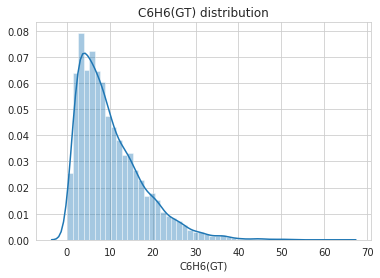

In [0]:
ax = sns.distplot(df['C6H6(GT)'].dropna(), norm_hist=True).set_title('C6H6(GT) distribution')

In [0]:
# ProfileReport(df)

## Data preparation

### Missing values

All missing values are filled/dropped with explanation of why some method was chosen

In [0]:
print(df.isnull().sum())

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


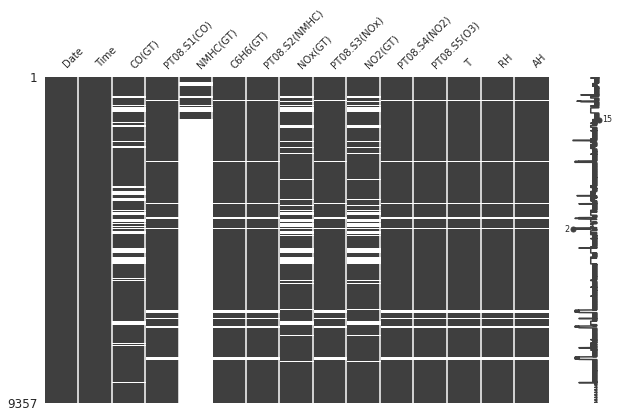

In [0]:
msno.matrix(df, figsize=(10, 6), fontsize=10);

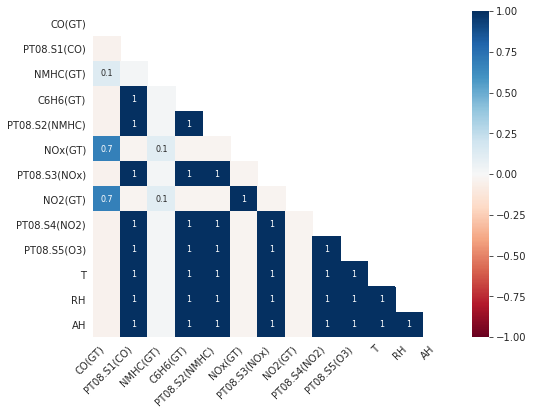

In [0]:
msno.heatmap(df, figsize=(8, 6), fontsize=10);

We see that 'NMHC(GT)' feature has most of data being missed. Probably, the detector was removed or broke up. We won't use this feature in our model.

In [0]:
df = df.drop('NMHC(GT)', axis=1)

Remove NaN values of target feature C6H6(GT) from our dataset.

In [0]:
number_before_removing = df.shape[0]
print('Number of rows before removing: ' + str(number_before_removing))

df = df[df['C6H6(GT)'].notnull()]

number_after_removing = df.shape[0]
print('Number of rows after removing: ' + str(number_after_removing))
print(str(number_before_removing - number_after_removing) + ' rows were removed as NaN values of C6H6(GT)')

Number of rows before removing: 9357
Number of rows after removing: 8991
366 rows were removed as NaN values of C6H6(GT)


To fill NaN values in non-target feature we'll use the median because it's resistant to asymmetry in data.

In [0]:
df = df.fillna(df.median())

### Add 'Datetime' feature

Let's add a new feature called 'Datetime' instead of two existing 'Date' and 'Time'.

In [0]:
df['Datetime'] = df['Date'] + ' ' + df['Time']
df['Datetime'] = df['Datetime'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H.%M.%S'))

df.head(10)

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00
5,10/03/2004,23.00.00,1.2,1197.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,2004-03-10 23:00:00
6,11/03/2004,00.00.00,1.2,1185.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,2004-03-11 00:00:00
7,11/03/2004,01.00.00,1.0,1136.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,2004-03-11 01:00:00
8,11/03/2004,02.00.00,0.9,1094.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,2004-03-11 02:00:00
9,11/03/2004,03.00.00,0.6,1010.0,1.7,561.0,178.0,1705.0,109.0,1235.0,501.0,10.3,60.2,0.7517,2004-03-11 03:00:00


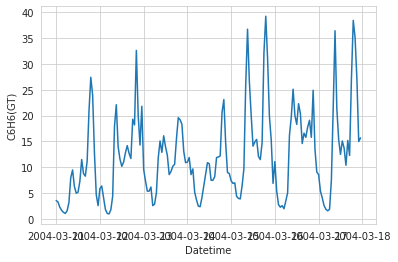

In [0]:
sns.lineplot(x='Datetime', y='C6H6(GT)', data=df.iloc[6:174]); #week

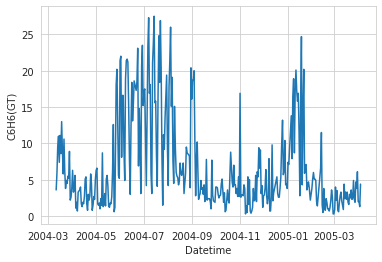

In [0]:
sns.lineplot(x='Datetime', y='C6H6(GT)', data=df.iloc[6::24]); #daily

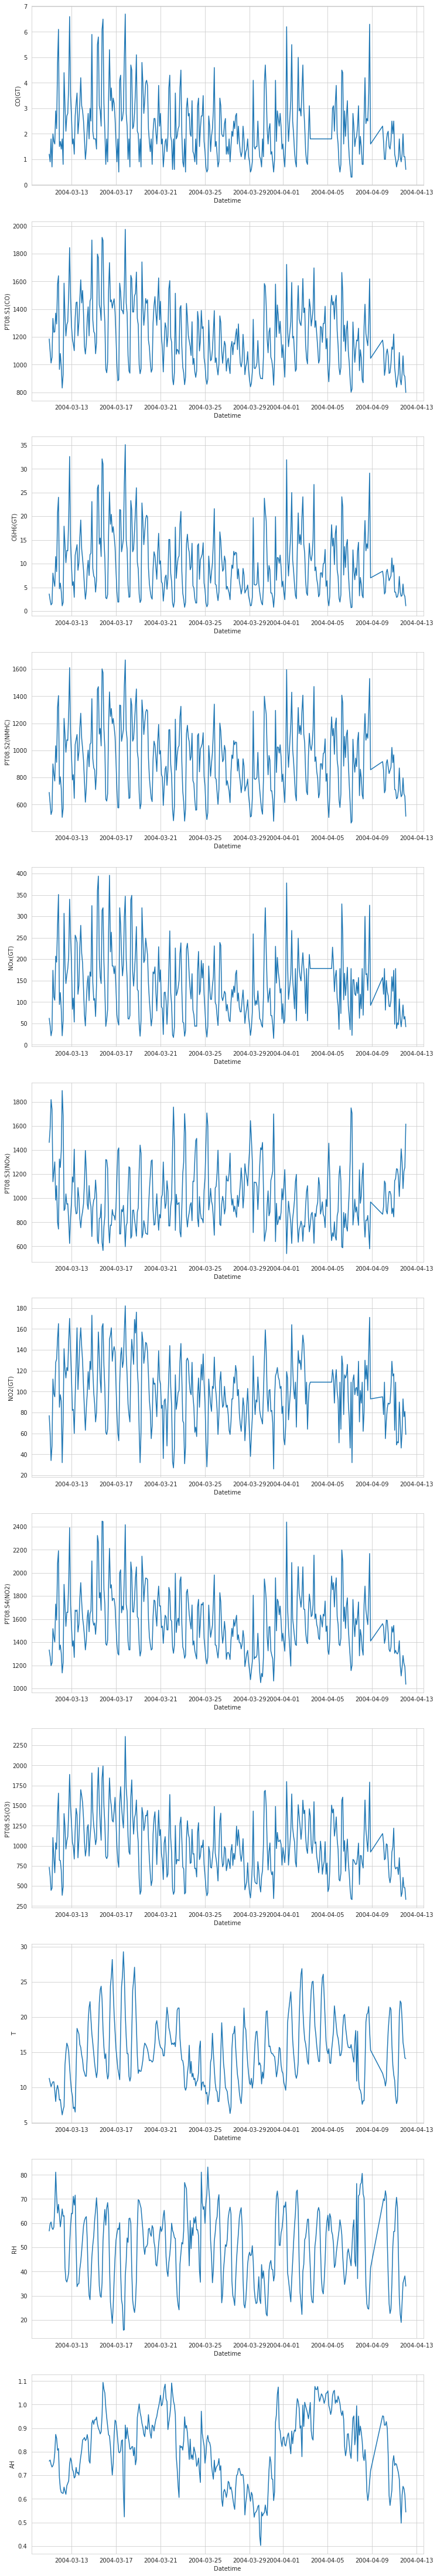

In [0]:
numeric_cols = list(df.select_dtypes(np.number))

plt.figure(figsize = (12, 80))
for i, col in enumerate(numeric_cols):
  plt.subplot(len(numeric_cols), 1, i+1)
  ax = sns.lineplot(x='Datetime', y=col, data=df.iloc[6:750:2]) #month
  # plt.tight_layout()

### Transform date format to numeric

Because linear regression doesn't work with date features

In [0]:
# df['Datetime'] = pd.to_datetime(df['Datetime']).map(datetime.timestamp) # to Unix timestamp

### Outliers

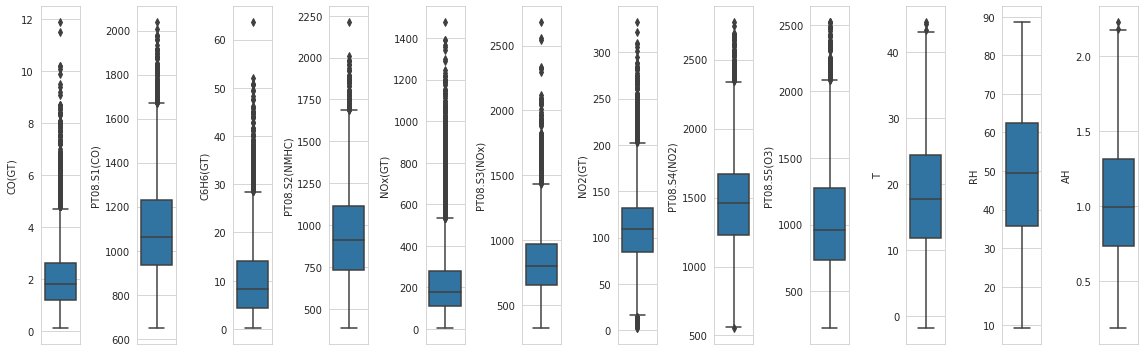

In [0]:
numeric_cols = list(df.select_dtypes(np.number))

plt.figure(figsize = (16, 5))
for i, col in enumerate(numeric_cols):
  plt.subplot(1, len(numeric_cols), i+1)
  ax = sns.boxplot(df[col], orient='v')
  plt.tight_layout();

### Features correlation

Since we can face with issues connected with multicollinearity while using highly correlated features, let's select features having absolute Pearson correlation higher than 0.7.

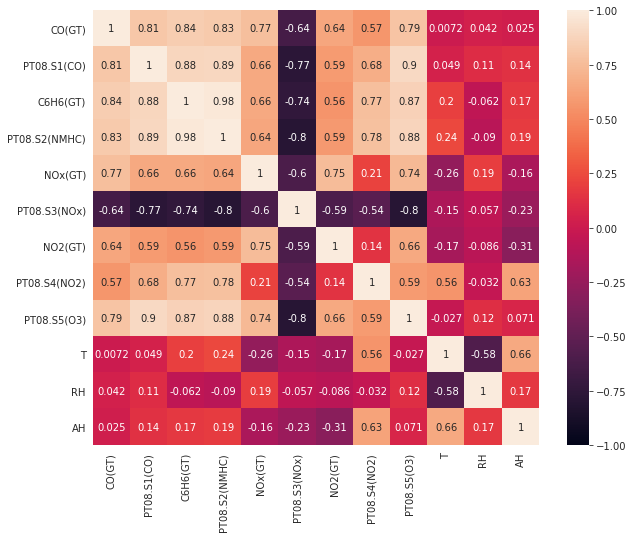

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1);

In [0]:
corr = df.corr()
condition = np.abs(corr['C6H6(GT)'] > 0.7)
correlated_features = list(corr.loc[condition, condition])
correlated_features.remove('C6H6(GT)')

print('Features with absolute correlation > 0.7:')
print(*correlated_features, sep = ", ")

Features with absolute correlation > 0.7:
CO(GT), PT08.S1(CO), PT08.S2(NMHC), PT08.S4(NO2), PT08.S5(O3)


In [0]:
df

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,2005-04-04 10:00:00
9353,04/04/2005,11.00.00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,2005-04-04 11:00:00
9354,04/04/2005,12.00.00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,2005-04-04 12:00:00
9355,04/04/2005,13.00.00,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,2005-04-04 13:00:00


### Clean data and train/test split

In [0]:
cleaned_df = df
x = cleaned_df.drop('C6H6(GT)', axis=1).to_numpy()
y = cleaned_df['C6H6(GT)'].to_numpy()

# train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=RANDOM_SEED)

x_train[:1,:]

array([['21/08/2004', '12.00.00', 1.8, 807.0, 658.0, 178.0, 1113.0,
        109.0, 1328.0, 428.0, 32.4, 26.3, 1.2523,
        Timestamp('2004-08-21 12:00:00')]], dtype=object)

In [0]:
# Leave only numeric features
x_train_numeric = x_train[:,2:13]
x_test_numeric = x_test[:,2:13]

## Normalization / scaling

We'll use MinMaxScaler() and Pipeline()

In [0]:
# numeric_cols = list(df.select_dtypes(np.number))
# min_max_scaler = MinMaxScaler()
# normalized_values = min_max_scaler.fit_transform(df[numeric_cols])
# df[numeric_cols] = pd.DataFrame(normalized_values, columns=numeric_cols)

# x_train_normalized = min_max_scaler.fit_transform(x_train_numeric, y_train)
# x_train_normalized = min_max_scaler.fit_transform(x_train_numeric)

## Metrics 
As well as reasoning behind each metric

We'll use three most popular metrics for regression analysis:
1. MSE (mean squared error)
2. MAE (mean absolute error)
3. Determination coefficient

The goal of usage both MSE and MAE is to compare those metrics. MSE has larger penalty for errors. An assumption is that as MSE is more sensitive to mistakes, we could have larger difference in accuracy for train and test data. 0 is the highest accuracy for both coefficients.

Determination coefficient shows which proportion of the diversity of objects in the entire target vector of our model this metic could explain. 1 is the highest accuracy and value less than 0 shows, that model is worse than constant model.

## Cross-validation

We'll use cross_validate() and the following metrics: 
* neg_mean_squared_error
* neg_mean_absolute_error
* r2

In [0]:
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

## Baseline model
linear regression without regularization

In [0]:
def print_metrics(data_name, y_true, y_pred):
  """
  Print metrics for the model

  :param: data_name name of data
  :param: y_true set of true answers
  :param: y_pred set of predicted values
  """

  accuracy = [['MSE', 'MAE', 'R2'],
              [str(mean_squared_error(y_true, y_pred)), 
               str(mean_absolute_error(y_true, y_pred)), 
               str(r2_score(y_true, y_pred))]]
  print('\n' + data_name + ' data prediction metrics')
  print(tabulate(accuracy, tablefmt='grid'))

def print_cv_metrics(scores):
  """
  Print metrics for the model

  :param: scores model scores
  """

  scores = scores.copy()  
  scores.pop('fit_time', None)
  scores.pop('score_time', None)
  mean_scores = dict()
  for k,v in scores.items():
      mean_scores[k] = abs(np.mean(v))

  accuracy = [['MSE', 'MAE', 'R2'],
              list(mean_scores.values())]
  print('\nAverage cross-validation metrics')
  print(tabulate(accuracy, tablefmt='grid'))

def test_model(regression, x, y, scoring, folds=5):
  pipeline = Pipeline(steps=[
                       ('normalize', MinMaxScaler()), 
                       ('model', regression)
  ])
  scores = cross_validate(pipeline, x, y, scoring=scoring, cv=folds)
  print_cv_metrics(scores)


In [0]:
test_model(LinearRegression(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+--------------------+--------------------+--------------------+
| MSE                | MAE                | R2                 |
+--------------------+--------------------+--------------------+
| 1.3370143751900183 | 0.8219447429298781 | 0.9757277725676223 |
+--------------------+--------------------+--------------------+


### Correlation engineering

In case we leave for the training only features with correlation higher than 0.7, we have almost the same accuracy.

In [0]:
# corr = cleaned_df.corr()
# condition = np.abs(corr['C6H6(GT)'] > 0.7)
# correlated_features = list(corr.loc[condition, condition])
# correlated_features.remove('C6H6(GT)')

# x_train, x_test, y_train, y_test = train_test_split(cleaned_df[correlated_features].values, cleaned_df['C6H6(GT)'].values, test_size = 0.2)

# regression = LinearRegression().fit(x_train, y_train)
# train_data_predicted = regression.predict(x_train)
# test_data_predicted = regression.predict(x_test)

# print_metrics('Train', y_train, train_data_predicted)
# print_metrics('Test', y_test, test_data_predicted)

In case we leave for the training only features with correlation lower than 0.8, accuracy is reduced.

In [0]:
# corr = cleaned_df.corr()
# condition = np.abs(corr['C6H6(GT)'] < 0.8)
# uncorrelated_features = list(corr.loc[condition, condition])

# x_train, x_test, y_train, y_test = train_test_split(cleaned_df[uncorrelated_features].values, cleaned_df['C6H6(GT)'].values, test_size = 0.2)

# regression = LinearRegression().fit(x_train, y_train)
# train_data_predicted = regression.predict(x_train)
# test_data_predicted = regression.predict(x_test)

# print_metrics('Train', y_train, train_data_predicted)
# print_metrics('Test', y_test, test_data_predicted)

### 1.5 IQR rule outliers removing

In [0]:
def remove_outliers(x, y, IQR_constant=1.5):
  """
  Remove outliers from inputs and outputs

  :param: x input values
  :param: y output values
  :param: IQR_constant value of IQR range
  """

  if (x.ndim != 1 and x.ndim != 2):
    print('x should have either 1 or 2 dimensions')
    return None
  if y.ndim != 1:
    print('y should have 1 dimension')
    return None
  if (x.shape[0] != y.shape[0]):
    print('x and x_new must be the same length')
    return None

  df_outliers = pd.DataFrame(list(x))
  df_outliers['y'] = y

  number_before_removing = df_outliers.shape[0]
  print('Number of rows before removing: ' + str(number_before_removing))

  q1 = df_outliers.quantile(0.25)
  q3 = df_outliers.quantile(0.75)
  IQR = q3 - q1
  IQR_condition = (df_outliers <= (q1 - IQR_constant * IQR)) | (df_outliers >= (q3 + IQR_constant * IQR))
  df_outliers = df_outliers[~IQR_condition.any(axis=1)]

  number_after_removing = df_outliers.shape[0]
  print('Number of rows after removing: ' + str(number_after_removing))
  print(str(number_before_removing - number_after_removing) + ' rows were removed as outliers applying IQR rule')
  
  result_x = df_outliers.drop('y', axis=1).to_numpy()
  result_y = df_outliers['y'].to_numpy()
  return result_x, result_y

In [0]:
x_iqr, y_iqr = remove_outliers(x_train_numeric, y_train)

Number of rows before removing: 7192
Number of rows after removing: 6131
1061 rows were removed as outliers applying IQR rule


In [0]:
test_model(LinearRegression(), x_iqr, y_iqr, scoring)


Average cross-validation metrics
+--------------------+--------------------+--------------------+
| MSE                | MAE                | R2                 |
+--------------------+--------------------+--------------------+
| 0.5653043288797215 | 0.5735375074256823 | 0.9803679626043895 |
+--------------------+--------------------+--------------------+


## Regularization

### L1-regularization (Lasso-regression)

In [0]:
test_model(Lasso(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+--------------------+-------------------+---------------------+
| MSE                | MAE               | R2                  |
+--------------------+-------------------+---------------------+
| 45.086883219887156 | 5.175937780291609 | 0.17734605210910312 |
+--------------------+-------------------+---------------------+


### L2-regularization (Ridge-regression)

In [0]:
test_model(Ridge(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+------------------+-------------------+--------------------+
| MSE              | MAE               | R2                 |
+------------------+-------------------+--------------------+
| 1.37859909065281 | 0.816074704833928 | 0.9750358120736913 |
+------------------+-------------------+--------------------+


### Elastic net

In [0]:
test_model(ElasticNet(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+-------------------+-------------------+---------------------+
| MSE               | MAE               | R2                  |
+-------------------+-------------------+---------------------+
| 46.92328395275003 | 5.289461787622628 | 0.14588502124474495 |
+-------------------+-------------------+---------------------+


## Feature engineering
Basic transformations (nonlinear)

### Nonlinear transformations

Natural logarithm transformation: 

$x \rightarrow ln(1+x)$

In [0]:
# if x is less than 0, the model can be a bit awkward
neg_values = np.sum(x_train_numeric < 0, axis=0)
print('Negative values in initial data: ' + str(neg_values))

x_train_numeric_positive = x_train_numeric[(x_train_numeric >= 0).all(axis=1)]
y_train_positive = y_train[(x_train_numeric >= 0).all(axis=1)]

Negative values in initial data: [ 0  0  0  0  0  0  0  0 11  0  0]


In [0]:
x_train_numeric_log = np.log1p(x_train_numeric_positive.astype('float64'))
x_train_numeric_log = np.column_stack((x_train_numeric_positive, x_train_numeric_log))

test_model(LinearRegression(), x_train_numeric_log, y_train_positive, scoring)


Average cross-validation metrics
+---------------------+--------------------+--------------------+
| MSE                 | MAE                | R2                 |
+---------------------+--------------------+--------------------+
| 0.07032365698236079 | 0.1737729293980517 | 0.9987313797607988 |
+---------------------+--------------------+--------------------+


Squared root transformation: 

$x \rightarrow \sqrt{x}$

In [0]:
x_train_numeric_sqrt = np.sqrt(x_train_numeric_positive.astype('float64'))
x_train_numeric_sqrt = np.column_stack((x_train_numeric_positive, x_train_numeric_sqrt))

test_model(LinearRegression(), x_train_numeric_sqrt, y_train_positive, scoring)


Average cross-validation metrics
+----------------------+---------------------+-------------------+
| MSE                  | MAE                 | R2                |
+----------------------+---------------------+-------------------+
| 0.035095420121882756 | 0.12389403517489801 | 0.999366553849614 |
+----------------------+---------------------+-------------------+


Square transformation: 

$x \rightarrow x^{2}$

In [0]:
x_train_numeric_square = np.square(x_train_numeric.astype('float64'))
x_train_numeric_square = np.column_stack((x_train_numeric, x_train_numeric_square))

test_model(LinearRegression(), x_train_numeric_square, y_train, scoring)


Average cross-validation metrics
+----------------------+---------------------+--------------------+
| MSE                  | MAE                 | R2                 |
+----------------------+---------------------+--------------------+
| 0.004743364040308849 | 0.04706063204250682 | 0.9999142924051666 |
+----------------------+---------------------+--------------------+


Sin transformation: 

$x \rightarrow sin(x)$

In [0]:
x_train_numeric_sin = np.sin(x_train_numeric.astype('float64'))
x_train_numeric_sin = np.column_stack((x_train_numeric, x_train_numeric_sin))

test_model(LinearRegression(), x_train_numeric_sin, y_train, scoring)


Average cross-validation metrics
+--------------------+--------------------+-------------------+
| MSE                | MAE                | R2                |
+--------------------+--------------------+-------------------+
| 1.3251413607611133 | 0.8082335347853977 | 0.975950259551755 |
+--------------------+--------------------+-------------------+


### Polynomial transformations

Polynomial transformation with 2 degrees

In [0]:
poly = PolynomialFeatures(2)
x_train_numeric_poly_2 = poly.fit_transform(x_train_numeric)

test_model(LinearRegression(), x_train_numeric_poly_2, y_train, scoring)


Average cross-validation metrics
+-----------------------+---------------------+--------------------+
| MSE                   | MAE                 | R2                 |
+-----------------------+---------------------+--------------------+
| 0.0030114658061407883 | 0.03836885375196969 | 0.9999457045387914 |
+-----------------------+---------------------+--------------------+


Polynomial transformation with 3 degrees

In [0]:
poly = PolynomialFeatures(3)
x_train_numeric_poly_3 = poly.fit_transform(x_train_numeric)

test_model(LinearRegression(), x_train_numeric_poly_3, y_train, scoring)


Average cross-validation metrics
+-----------------------+---------------------+--------------------+
| MSE                   | MAE                 | R2                 |
+-----------------------+---------------------+--------------------+
| 0.0011062759180007794 | 0.02639051565453012 | 0.9999799302167751 |
+-----------------------+---------------------+--------------------+


Polynomial transformation with 4 degrees, interaction-only

In [0]:
poly = PolynomialFeatures(4, interaction_only=True)
x_train_numeric_poly_4 = poly.fit_transform(x_train_numeric)

test_model(LinearRegression(), x_train_numeric_poly_4, y_train, scoring)


Average cross-validation metrics
+----------------------+---------------------+--------------------+
| MSE                  | MAE                 | R2                 |
+----------------------+---------------------+--------------------+
| 0.013390303911861301 | 0.04787585187045773 | 0.9997668015317627 |
+----------------------+---------------------+--------------------+


### Adding time-based features

* hours per day
* days per week
* months per year

In [0]:
x_train[0,:]

array(['21/08/2004', '12.00.00', 1.8, 807.0, 658.0, 178.0, 1113.0, 109.0,
       1328.0, 428.0, 32.4, 26.3, 1.2523,
       Timestamp('2004-08-21 12:00:00')], dtype=object)

In [0]:
def get_time_of_day(hour):
  time_of_day = 'night'
  if (6 <= hour < 12):
    time_of_day = 'morning'
  if (12 <= hour < 18):
    time_of_day = 'afternoon'
  if (18 <= hour < 24):
    time_of_day = 'evening'
  return time_of_day

x_train_daytime = np.array([get_time_of_day(dt.hour) for dt in x_train[:,13]])

In [0]:
x_train_time = x_train[:,1]
x_train_days = np.array([dt.weekday() for dt in x_train[:,13]])
x_train_months = np.array([dt.strftime("%b") for dt in x_train[:,13]])

**Label encoding**

In [0]:
# le = LabelEncoder() # the idea behind is that LabelEncoder is for converting target variable
onc = OrdinalEncoder() # while OrdinalEncoder is for converting features
x_train_daytime_onc = onc.fit_transform(x_train_daytime.reshape(-1,1))
print('Day part classes:\n' + str(onc.categories_))
x_train_time_onc = onc.fit_transform(x_train_time.reshape(-1,1))
print('Time classes:\n' + str(onc.categories_))
x_train_days_onc = onc.fit_transform(x_train_days.reshape(-1,1))
print('Day classes:\n ' + str(onc.categories_))
x_train_months_onc = onc.fit_transform(x_train_months.reshape(-1,1))
print('Month classes:\n' + str(onc.categories_))

Day part classes:
[array(['afternoon', 'evening', 'morning', 'night'], dtype='<U9')]
Time classes:
[array(['00.00.00', '01.00.00', '02.00.00', '03.00.00', '04.00.00',
       '05.00.00', '06.00.00', '07.00.00', '08.00.00', '09.00.00',
       '10.00.00', '11.00.00', '12.00.00', '13.00.00', '14.00.00',
       '15.00.00', '16.00.00', '17.00.00', '18.00.00', '19.00.00',
       '20.00.00', '21.00.00', '22.00.00', '23.00.00'], dtype=object)]
Day classes:
 [array([0, 1, 2, 3, 4, 5, 6])]
Month classes:
[array(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype='<U3')]


In [0]:
x_train_numeric_onc = np.column_stack((x_train_numeric, x_train_daytime_onc, x_train_time_onc, x_train_days_onc, x_train_months_onc))

test_model(LinearRegression(), x_train_numeric_onc, y_train, scoring)


Average cross-validation metrics
+--------------------+--------------------+--------------------+
| MSE                | MAE                | R2                 |
+--------------------+--------------------+--------------------+
| 1.2509864494012888 | 0.7926714396510965 | 0.9772673719143021 |
+--------------------+--------------------+--------------------+


**One-hot encoding**

In [0]:
enc = OneHotEncoder(sparse=False)
x_train_daytime_enc = enc.fit_transform(x_train_daytime.reshape(-1,1))
print('Day part classes:\n' + str(enc.categories_))
x_train_time_enc = enc.fit_transform(x_train_time.reshape(-1,1))
print('Time classes:\n' + str(enc.categories_))
x_train_days_enc = enc.fit_transform(x_train_days.reshape(-1,1))
print('Day classes:\n' + str(enc.categories_))
x_train_months_enc = enc.fit_transform(x_train_months.reshape(-1,1))
print('Month classes:\n' + str(enc.categories_))

Day part classes:
[array(['afternoon', 'evening', 'morning', 'night'], dtype='<U9')]
Time classes:
[array(['00.00.00', '01.00.00', '02.00.00', '03.00.00', '04.00.00',
       '05.00.00', '06.00.00', '07.00.00', '08.00.00', '09.00.00',
       '10.00.00', '11.00.00', '12.00.00', '13.00.00', '14.00.00',
       '15.00.00', '16.00.00', '17.00.00', '18.00.00', '19.00.00',
       '20.00.00', '21.00.00', '22.00.00', '23.00.00'], dtype=object)]
Day classes:
[array([0, 1, 2, 3, 4, 5, 6])]
Month classes:
[array(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype='<U3')]


In [0]:
x_train_numeric_enc = np.column_stack((x_train_numeric, x_train_daytime_enc, x_train_time_enc, x_train_days_enc, x_train_months_enc))

test_model(LinearRegression(), x_train_numeric_enc, y_train, scoring)


Average cross-validation metrics
+--------------------+--------------------+--------------------+
| MSE                | MAE                | R2                 |
+--------------------+--------------------+--------------------+
| 1.0573957674174792 | 0.7166990565088669 | 0.9808025642868421 |
+--------------------+--------------------+--------------------+


**Dummy encoding**

In [0]:
enc = OneHotEncoder(drop='first', sparse=False)
x_train_daytime_enc = enc.fit_transform(x_train_daytime.reshape(-1,1))
print('Day part classes:\n' + str(enc.categories_))
x_train_time_enc = enc.fit_transform(x_train_time.reshape(-1,1))
print('Time classes:\n' + str(enc.categories_))
x_train_days_enc = enc.fit_transform(x_train_days.reshape(-1,1))
print('Day classes:\n' + str(enc.categories_))
x_train_months_enc = enc.fit_transform(x_train_months.reshape(-1,1))
print('Month classes:\n' + str(enc.categories_))

Day part classes:
[array(['afternoon', 'evening', 'morning', 'night'], dtype='<U9')]
Time classes:
[array(['00.00.00', '01.00.00', '02.00.00', '03.00.00', '04.00.00',
       '05.00.00', '06.00.00', '07.00.00', '08.00.00', '09.00.00',
       '10.00.00', '11.00.00', '12.00.00', '13.00.00', '14.00.00',
       '15.00.00', '16.00.00', '17.00.00', '18.00.00', '19.00.00',
       '20.00.00', '21.00.00', '22.00.00', '23.00.00'], dtype=object)]
Day classes:
[array([0, 1, 2, 3, 4, 5, 6])]
Month classes:
[array(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype='<U3')]


In [0]:
x_train_numeric_enc = np.column_stack((x_train_numeric, x_train_daytime_enc, x_train_time_enc, x_train_days_enc, x_train_months_enc))

test_model(LinearRegression(), x_train_numeric_enc, y_train, scoring)


Average cross-validation metrics
+--------------------+--------------------+--------------------+
| MSE                | MAE                | R2                 |
+--------------------+--------------------+--------------------+
| 1.0509326765631724 | 0.7146615291059819 | 0.9809227604668962 |
+--------------------+--------------------+--------------------+


### Result Graphs

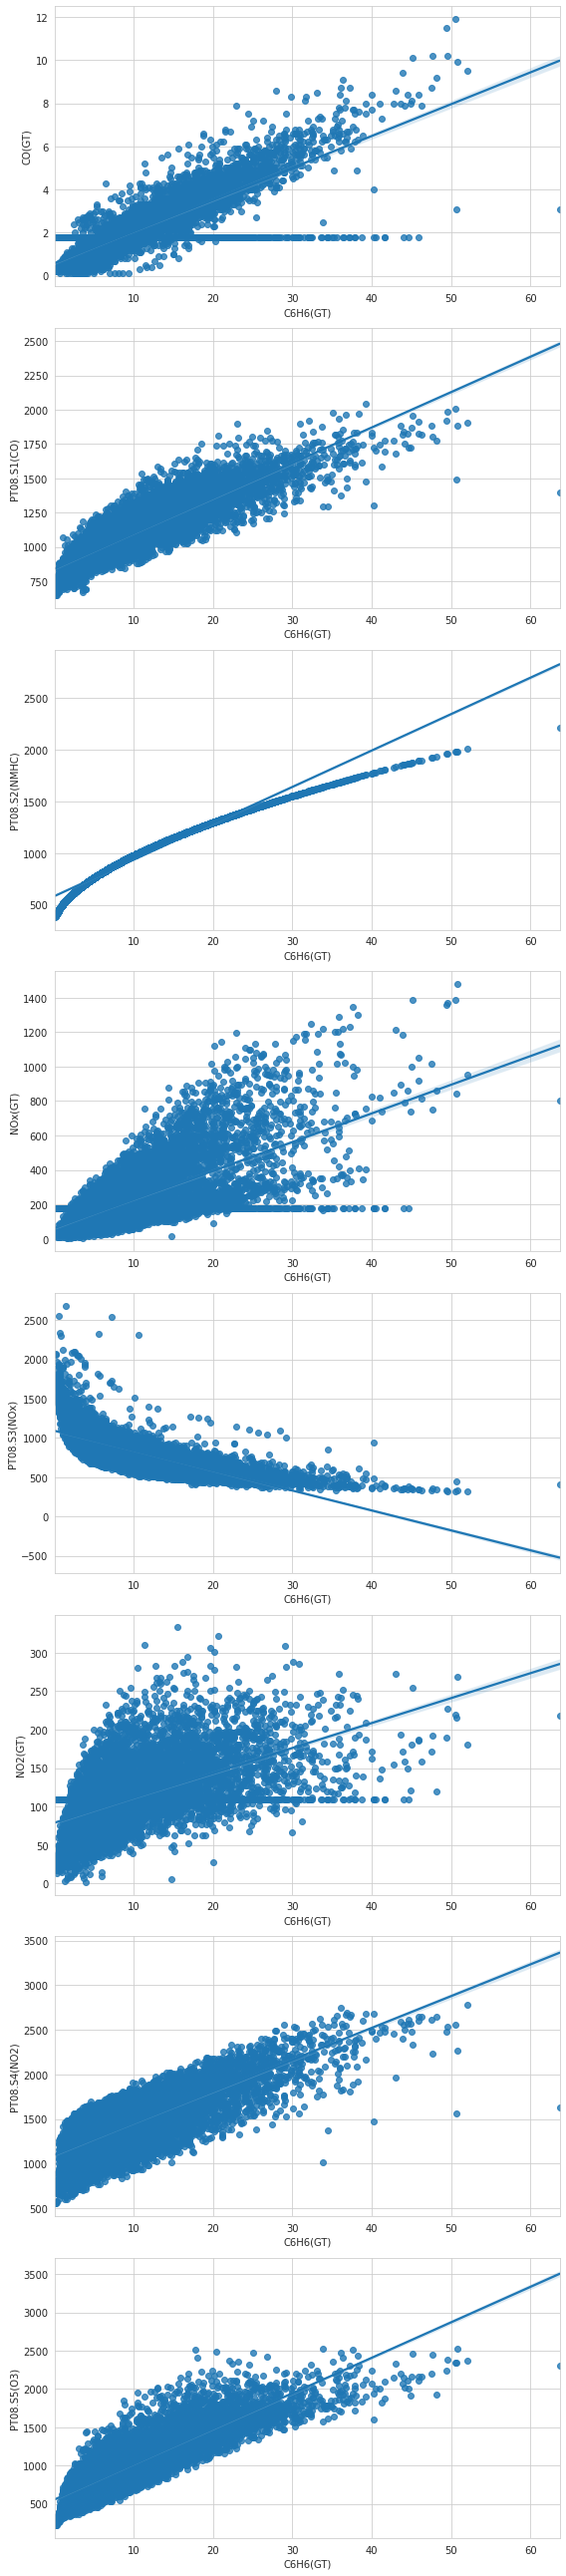

In [0]:
plotting_cols = ['CO(GT)',	'PT08.S1(CO)', 'PT08.S2(NMHC)',	'NOx(GT)',	'PT08.S3(NOx)',	'NO2(GT)',	'PT08.S4(NO2)',	'PT08.S5(O3)']

plt.figure(figsize = (8, 36))
for i, col in enumerate(plotting_cols):
  plt.subplot(len(plotting_cols), 1, i+1)
  ax = sns.regplot(x='C6H6(GT)', y=col, data=cleaned_df);
  plt.tight_layout()

## Feature importance, hyperparameters tuning

### Feature importance

In [0]:
baseline_pipeline = Pipeline(steps=[
                       ('normalize', MinMaxScaler()), 
                       ('model', LinearRegression())
])
estimator = cross_validate(baseline_pipeline, x_train_numeric, y_train, return_estimator=True, scoring=scoring, cv=5)
baseline_pipeline = estimator['estimator'][0]

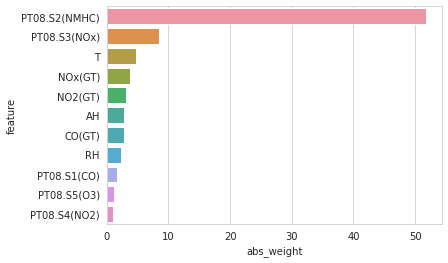

In [0]:
model = baseline_pipeline['model']
importance = pd.DataFrame({
      'abs_weight': np.abs(model.coef_),
      'feature': cleaned_df.drop(['C6H6(GT)', 'Date', 'Time', 'Datetime'], axis=1).columns
})
importance = importance.sort_values(by='abs_weight', ascending=False)
sns.barplot(y='feature', x='abs_weight', data=importance, orient='h');

In [0]:
model.coef_

array([ 2.70541345,  1.70570959, 51.70765919,  3.73228977,  8.40691727,
       -3.12525909,  1.04685798, -1.1573622 , -4.75219953, -2.25811897,
        2.75299489])

### Hyperparameters tuning

**Lasso regression**

In [0]:
model = Lasso()
params = {'alpha':[0.5, 0.25, 0.1, 0.075, 0.005, 0.025, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]}

grid = GridSearchCV(estimator=model, param_grid=params, cv=5)
grid.fit(x_train_numeric, y_train)

print('Best alpha: ' + str(grid.best_estimator_.alpha))
print('Best r2: ' + str(grid.best_score_))

Best alpha: 0.0001
Best r2: 0.9757277865113749


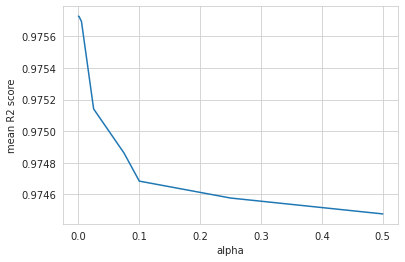

In [0]:
grid_scores = grid.cv_results_['mean_test_score']
data = pd.DataFrame({'params': params['alpha'], 'grid_scores': grid_scores})

ax = sns.lineplot(x='params', y='grid_scores', data=data)
ax.set_xlabel('alpha');
ax.set_ylabel('mean R2 score');

In [0]:
test_model(Lasso(alpha=0.0001), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+--------------------+-------------------+-------------------+
| MSE                | MAE               | R2                |
+--------------------+-------------------+-------------------+
| 1.3370070723306728 | 0.821310259747565 | 0.975728467913856 |
+--------------------+-------------------+-------------------+


**Ridge regression**

In [0]:
model = Ridge()
params = {'alpha':[10, 5, 4, 3, 2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]}

grid = GridSearchCV(estimator=model, param_grid=params, cv=5)
grid.fit(x_train_numeric, y_train)

print('Best alpha: ' + str(grid.best_estimator_.alpha))
print('Best r2: ' + str(grid.best_score_))

Best alpha: 2
Best r2: 0.9757280601004876


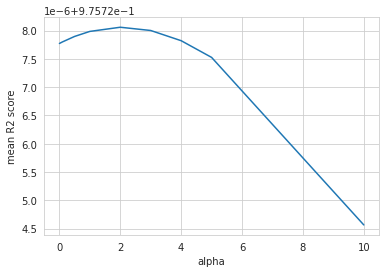

In [0]:
grid_scores = grid.cv_results_['mean_test_score']
data = pd.DataFrame({'params': params['alpha'], 'grid_scores': grid_scores})

ax = sns.lineplot(x='params', y='grid_scores', data=data)
ax.set_xlabel('alpha');
ax.set_ylabel('mean R2 score');

In [0]:
test_model(Ridge(alpha=2), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+-------------------+--------------------+--------------------+
| MSE               | MAE                | R2                 |
+-------------------+--------------------+--------------------+
| 1.466406646084988 | 0.8276374757712086 | 0.9734721813871128 |
+-------------------+--------------------+--------------------+


**Elastic net**

In [0]:
model = ElasticNet()
params = {'alpha':[0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
          'l1_ratio':[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]}

grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(x_train_numeric, y_train)

print('Best alpha: ' + str(grid.best_estimator_.alpha))
print('Best l1_ratio: ' + str(grid.best_estimator_.l1_ratio))
print('Best r2: ' + str(grid.best_score_))

Best alpha: 0.0005
Best l1_ratio: 1e-05
Best r2: 0.9757280165474833


In [0]:
test_model(ElasticNet(alpha=0.0005, l1_ratio=0.00005), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+--------------------+-------------------+--------------------+
| MSE                | MAE               | R2                 |
+--------------------+-------------------+--------------------+
| 1.5511629243057183 | 0.843004912004847 | 0.9719489329628201 |
+--------------------+-------------------+--------------------+


## Statistics material used 
(residual analysis, factor-importance hypothesis testing)

Let's define the importance of regressors for linear regression.

$H_0$ - the feature isn't important for our model

$H_1$ - the feature is important for our model

p-value for all of our features is small enough. So, there's no unimportant parameters in our model.

In [0]:
p_vals = f_regression(x_train_numeric, y_train)[1]
for column, pvalue in zip(df.drop('C6H6(GT)', axis=1).columns.values, p_vals):
  print('Feature: {}, p-value: {}'.format(column, pvalue))

Feature: Date, p-value: 0.0
Feature: Time, p-value: 0.0
Feature: CO(GT), p-value: 0.0
Feature: PT08.S1(CO), p-value: 0.0
Feature: PT08.S2(NMHC), p-value: 0.0
Feature: NOx(GT), p-value: 0.0
Feature: PT08.S3(NOx), p-value: 0.0
Feature: NO2(GT), p-value: 0.0
Feature: PT08.S4(NO2), p-value: 1.3996590172521e-61
Feature: PT08.S5(O3), p-value: 5.944828107021366e-06
Feature: T, p-value: 3.567176682817291e-46


## Non-classic regression 
SVM-regression, Kernel-regression, SGD-regression

### SVM-regression

In [0]:
test_model(SVR(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+--------------------+---------------------+--------------------+
| MSE                | MAE                 | R2                 |
+--------------------+---------------------+--------------------+
| 1.0082972430757984 | 0.23162021592471488 | 0.9822526598061094 |
+--------------------+---------------------+--------------------+


### SGD-regression

In [0]:
test_model(SGDRegressor(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+--------------------+--------------------+--------------------+
| MSE                | MAE                | R2                 |
+--------------------+--------------------+--------------------+
| 1.9294766568702613 | 0.9395620801804736 | 0.9651330397124539 |
+--------------------+--------------------+--------------------+


### Kernel-regression

In [0]:
test_model(KernelRidge(), x_train_numeric, y_train, scoring)


Average cross-validation metrics
+-------------------+--------------------+--------------------+
| MSE               | MAE                | R2                 |
+-------------------+--------------------+--------------------+
| 1.562223778606032 | 0.8894596535480133 | 0.9717305892456437 |
+-------------------+--------------------+--------------------+
